In [120]:
%%capture
!pip install -U vectorbt
!pip install quantstats
!pip install --upgrade mplfinance
!pip install -U kaleido

In [2]:
# Imports
import pandas as pd
import datetime
import os
import numpy as np
import time
import vectorbt as vbt
import shutil
import quantstats as qs
import matplotlib.pyplot as plt

In [3]:
%%capture
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [7]:
def resample_ohlc(df, timeframe):
    """
    Resamples an OHLC DataFrame to the specified timeframe (in minutes).
    Valid timeframes are: 5, 15, 30, 45, 60.
    Returns a new DataFrame with the resampled data.
    """
    df.index = df['datetime']

    valid_timeframes = [5, 15, 30, 45, 60]
    if timeframe not in valid_timeframes:
        raise ValueError(f"Invalid timeframe: {timeframe}. Valid timeframes are: {valid_timeframes}")

    # Calculate the resampling frequency
    resample_freq = f"{timeframe}T"

    # Resample OHLC data to the desired timeframe
    ohlc_dict = {'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'}
    df_resampled = df.resample(resample_freq).apply(ohlc_dict)

    # Drop any rows with missing data
    df_resampled.dropna(inplace=True)
    df_resampled['datetime'] = df_resampled.index
    return df_resampled


def trim_to_date_range(data, first_day, last_day):
    return data[(data['datetime'].dt.date >= first_day) & (data['datetime'].dt.date <= last_day)]

In [53]:
datapath_1m = "/content/gdrive/MyDrive/Algorithmic Trading System (ATS)/Data/Historical/Processed/TwelveData_1m/SPY_1m.csv"

data_1m = pd.read_csv(datapath_1m, date_parser=True).drop('Unnamed: 0', axis=1)
data_1m['datetime'] = pd.to_datetime(data_1m['datetime'])
data_1m.index = data_1m['datetime']


# Trim data 
first_day = min(data_1m["datetime"].dt.date) 
last_day = max(data_1m["datetime"].dt.date) 

# trim and resample
data_1m = trim_to_date_range(data_1m, first_day, last_day)
data_5m = resample_ohlc(data_1m, 5).dropna()
data_15m = resample_ohlc(data_1m, 15).dropna()

## Strategy with SMA 

Hyperparameter used are randomly selected. They will be tuned later 

In [27]:
def get_entry_exit_signals_sma(data_1m, data_5m, data_15m, ma_periods):
    slow_prd, med_prd, fast_prd, exit_slow, exit_fast = ma_periods[0], ma_periods[1], ma_periods[2], ma_periods[3], ma_periods[4]


    assert slow_prd > med_prd > fast_prd and exit_slow > exit_fast

    # Resample the dataframes to a common frequency
    data = data_1m.resample('1T').last().dropna()
    data1 = data_5m.resample('1T').last().dropna()
    data2 = data_15m.resample('1T').last().dropna()

    # Compute the moving average indicators for each timeframe
    vr_tf0_slow = data['close'].rolling(slow_prd).mean()
    vr_tf0_med =  data['close'].rolling(med_prd).mean()
    vr_tf0_fast = data['close'].rolling(fast_prd).mean()

    vr_tf1_slow = data1['close'].rolling(slow_prd).mean()
    vr_tf1_med = data1['close'].rolling(med_prd).mean()
    vr_tf1_fast = data1['close'].rolling(fast_prd).mean()

    vr_tf1_slow_exit = data1['close'].rolling(exit_slow).mean()
    vr_tf1_fast_exit = data1['close'].rolling(exit_fast).mean()

    vr_tf2_slow = data2['close'].rolling(slow_prd).mean()
    vr_tf2_med = data2['close'].rolling(med_prd).mean()
    vr_tf2_fast = data2['close'].rolling(fast_prd).mean()

    # Combine the indicators into a single DataFrame
    signals = pd.DataFrame(index=data.index)
    signals['vr_tf0_slow'] = vr_tf0_slow
    signals['vr_tf0_med']  = vr_tf0_med
    signals['vr_tf0_fast'] = vr_tf0_fast
    signals['vr_tf1_slow'] = vr_tf1_slow
    signals['vr_tf1_med']  = vr_tf1_med
    signals['vr_tf1_fast'] = vr_tf1_fast
    signals['vr_tf1_slow_exit']  = vr_tf1_slow_exit
    signals['vr_tf1_fast_exit']  = vr_tf1_fast_exit
    signals['vr_tf2_slow'] = vr_tf2_slow
    signals['vr_tf2_med']  = vr_tf2_med
    signals['vr_tf2_fast'] = vr_tf2_fast

    # forward fill the emas
    signals = signals.ffill()

    # Define entry and exit signals based on the conditions
    entry_long  = (signals['vr_tf2_fast'] > signals['vr_tf2_med']) & (signals['vr_tf2_med'] > signals['vr_tf2_slow']) &\
                  (signals['vr_tf1_fast'] > signals['vr_tf1_med']) & (signals['vr_tf1_med'] > signals['vr_tf1_slow'])  &\
                  (signals['vr_tf0_fast'] > signals['vr_tf0_med']) & (signals['vr_tf0_med'] > signals['vr_tf0_slow'])
                  
    entry_short = (signals['vr_tf2_fast'] < signals['vr_tf2_med']) & (signals['vr_tf2_med'] < signals['vr_tf2_slow']) &\
                  (signals['vr_tf1_fast'] < signals['vr_tf1_med']) & (signals['vr_tf1_med'] < signals['vr_tf1_slow'])  &\
                  (signals['vr_tf0_fast'] < signals['vr_tf0_med']) & (signals['vr_tf0_med'] < signals['vr_tf0_slow'])

    exit_long   = (signals['vr_tf1_fast_exit'] < signals['vr_tf1_slow_exit'])

    exit_short  = (signals['vr_tf1_fast_exit'] > signals['vr_tf1_slow_exit'])


    return signals, entry_long, entry_short, exit_long, exit_short

In [24]:
def adjust_entries_exits_sizes(signals, entry_long, entry_short, exit_long, exit_short):
    all_signals = pd.DataFrame(index = signals.index)
    all_signals['entry_long'] = entry_long
    all_signals['entry_short'] = entry_short
    all_signals['exit_long'] = exit_long
    all_signals['exit_short'] = exit_short

    size = pd.Series(np.zeros(len(signals)), index=signals.index) 
    start_index = datetime.datetime(2000, 1, 1)
    end_index = signals.index[-1]

    while start_index < end_index:
        all_signals = all_signals[all_signals.index > start_index]
        
        # find the first occurance of an entry either short or long
        ts_entry_short = all_signals[all_signals['entry_short'] == True].index[0] if all_signals[all_signals['entry_short'] == True].shape[0] else end_index
        ts_entry_long = all_signals[all_signals['entry_long'] == True].index[0]   if all_signals[all_signals['entry_long'] == True].shape[0]  else end_index

        if ts_entry_long < ts_entry_short:
            future_tmp = all_signals[all_signals.index > ts_entry_long]['exit_long']
            ts_exit_long = future_tmp[future_tmp == True].index[0] if future_tmp[future_tmp == True].shape[0] else end_index 

            size.loc[(size.index >= ts_entry_long) & (size.index <= ts_exit_long)] = 1

            start_index = ts_exit_long

        else:
            future_tmp = all_signals[all_signals.index > ts_entry_short]['exit_short']
            ts_exit_short = future_tmp[future_tmp == True].index[0] if future_tmp[future_tmp == True].shape[0] else end_index 
            
            size.loc[(size.index >= ts_entry_short) & (size.index <= ts_exit_short)] = -1

            start_index = ts_exit_short 
    
    return size


In [25]:
# Hyperparameters randomly selected 
slow_prd, med_prd, fast_prd, exit_slow, exit_fast  = 10, 8, 5, 6, 3

In [ ]:
signals, entry_long, entry_short, exit_long, exit_short = get_entry_exit_signals_sma(data_1m, data_5m, data_15m, [slow_prd, med_prd, fast_prd, exit_slow, exit_fast])
size = adjust_entries_exits_sizes(signals, entry_long, entry_short, exit_long, exit_short)


In [28]:
vbt.settings.portfolio['init_cash'] = 10000  # in $
vbt.settings.portfolio['fees'] = 0.00025      # in %
vbt.settings.portfolio['slippage'] = 0.0001 # in %

portfolio_percentage = 0.5

# Create a Portfolio instance
portfolio = vbt.Portfolio.from_orders(data_1m['close'].vbt.bshift(1),
                                      size = size*portfolio_percentage,
                                      size_type = "targetpercent", freq="1 T")


In [98]:
trade_list = portfolio.positions.records
trade_list['entry_datetime'] = [data_1m.index[entry_idx] for entry_idx in trade_list['entry_idx']]
trade_list['exit_datetime'] = [data_1m.index[exit_idx] for exit_idx in trade_list['exit_idx']]
trade_list.index = trade_list['exit_datetime']
trade_list_res = trade_list['pnl'].resample('B').sum()
print("Sharpe ratio of the backtest was: ", qs.stats.sharpe(trade_list_res))

Sharpe ratio of the backtest was:  -3.2232368671887603


Text(0, 0.5, 'Cummulative Profit Loss')

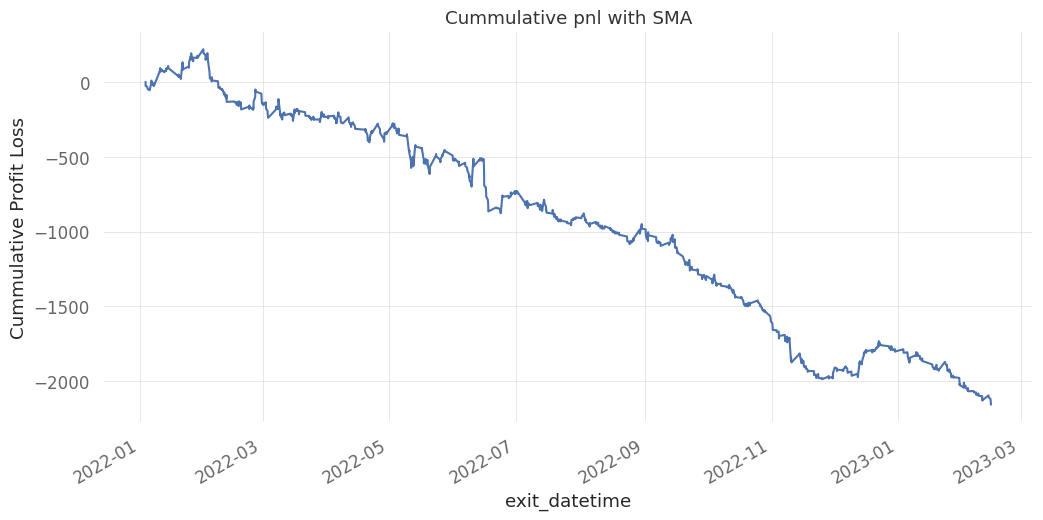

In [30]:
plt.figure(figsize = (12.00, 5.75))
plt.title("Cummulative pnl with SMA")
trade_list['pnl'].cumsum().plot()
plt.ylabel("Cummulative Profit Loss")

## Strategy with EMA

In [31]:
def get_entry_exit_signals_ema(data_1m, data_5m, data_15m, ma_periods):
    slow_prd, med_prd, fast_prd, exit_slow, exit_fast = ma_periods[0], ma_periods[1], ma_periods[2], ma_periods[3], ma_periods[4]


    assert slow_prd > med_prd > fast_prd and exit_slow > exit_fast

    # Resample the dataframes to a common frequency
    data = data_1m.resample('1T').last().dropna()
    data1 = data_5m.resample('1T').last().dropna()
    data2 = data_15m.resample('1T').last().dropna()

    # Compute the moving average indicators for each timeframe
    vr_tf0_slow = data['close'].ewm(span = slow_prd).mean()
    vr_tf0_med =  data['close'].ewm(span = med_prd).mean()
    vr_tf0_fast = data['close'].ewm(span = fast_prd).mean()

    vr_tf1_slow = data1['close'].ewm(span = slow_prd).mean()
    vr_tf1_med =  data1['close'].ewm(span = med_prd).mean()
    vr_tf1_fast = data1['close'].ewm(span = fast_prd).mean()

    vr_tf1_slow_exit = data1['close'].ewm(span = exit_slow).mean()
    vr_tf1_fast_exit = data1['close'].ewm(span = exit_fast).mean()

    vr_tf2_slow = data2['close'].ewm(span = slow_prd).mean()
    vr_tf2_med =  data2['close'].ewm(span = med_prd).mean()
    vr_tf2_fast = data2['close'].ewm(span = fast_prd).mean()

    # Combine the indicators into a single DataFrame
    signals = pd.DataFrame(index=data.index)
    signals['vr_tf0_slow'] = vr_tf0_slow
    signals['vr_tf0_med']  = vr_tf0_med
    signals['vr_tf0_fast'] = vr_tf0_fast
    signals['vr_tf1_slow'] = vr_tf1_slow
    signals['vr_tf1_med']  = vr_tf1_med
    signals['vr_tf1_fast'] = vr_tf1_fast
    signals['vr_tf1_slow_exit']  = vr_tf1_slow_exit
    signals['vr_tf1_fast_exit']  = vr_tf1_fast_exit
    signals['vr_tf2_slow'] = vr_tf2_slow
    signals['vr_tf2_med']  = vr_tf2_med
    signals['vr_tf2_fast'] = vr_tf2_fast

    # forward fill the emas
    signals = signals.ffill()

    # Define entry and exit signals based on the conditions
    entry_long  = (signals['vr_tf2_fast'] > signals['vr_tf2_med']) & (signals['vr_tf2_med'] > signals['vr_tf2_slow']) &\
                  (signals['vr_tf1_fast'] > signals['vr_tf1_med']) & (signals['vr_tf1_med'] > signals['vr_tf1_slow'])  &\
                  (signals['vr_tf0_fast'] > signals['vr_tf0_med']) & (signals['vr_tf0_med'] > signals['vr_tf0_slow'])
                  
    entry_short = (signals['vr_tf2_fast'] < signals['vr_tf2_med']) & (signals['vr_tf2_med'] < signals['vr_tf2_slow']) &\
                  (signals['vr_tf1_fast'] < signals['vr_tf1_med']) & (signals['vr_tf1_med'] < signals['vr_tf1_slow'])  &\
                  (signals['vr_tf0_fast'] < signals['vr_tf0_med']) & (signals['vr_tf0_med'] < signals['vr_tf0_slow'])

    exit_long   = (signals['vr_tf1_fast_exit'] < signals['vr_tf1_slow_exit'])

    exit_short  = (signals['vr_tf1_fast_exit'] > signals['vr_tf1_slow_exit'])


    return signals, entry_long, entry_short, exit_long, exit_short

In [32]:
signals, entry_long, entry_short, exit_long, exit_short = get_entry_exit_signals_ema(data_1m, data_5m, data_15m, [slow_prd, med_prd, fast_prd, exit_slow, exit_fast])
size = adjust_entries_exits_sizes(signals, entry_long, entry_short, exit_long, exit_short)


In [40]:
vbt.settings.portfolio['init_cash'] = 10000  # in $
vbt.settings.portfolio['fees'] = 0.00025      # in %
vbt.settings.portfolio['slippage'] = 0.0001 # in %

portfolio_percentage = 0.5

# Create a Portfolio instance
portfolio_ema = vbt.Portfolio.from_orders(data_1m['close'].vbt.bshift(1),
                                      size = size*portfolio_percentage,
                                      size_type = "targetpercent", freq="1 T")


In [97]:
trade_list_ema = portfolio_ema.positions.records
trade_list_ema['entry_datetime'] = [data_1m.index[entry_idx] for entry_idx in trade_list_ema['entry_idx']]
trade_list_ema['exit_datetime'] = [data_1m.index[exit_idx] for exit_idx in trade_list_ema['exit_idx']]
trade_list_ema.index = trade_list_ema['exit_datetime']
trade_list_res_ema = trade_list_ema['pnl'].resample('B').sum()
print("Sharpe ratio of the backtest was: ", qs.stats.sharpe(trade_list_res_ema))

Sharpe ratio of the backtest was:  1.544041183233584


Text(0, 0.5, 'Cummulative Profit Loss')

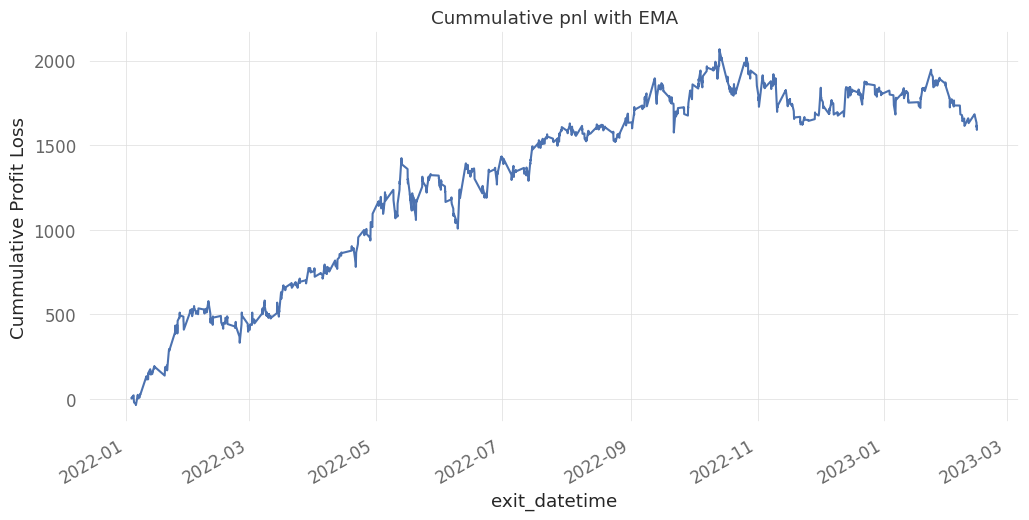

In [42]:
plt.figure(figsize = (12.00, 5.75))
plt.title("Cummulative pnl with EMA")
trade_list_ema['pnl'].cumsum().plot()
plt.ylabel("Cummulative Profit Loss")

## Comparison

SMA vs EMA 

As seen above, EMA performs better than an SMA for this strategy.

The periods were selected randomly and the trade conditions were exactly same for both cases.

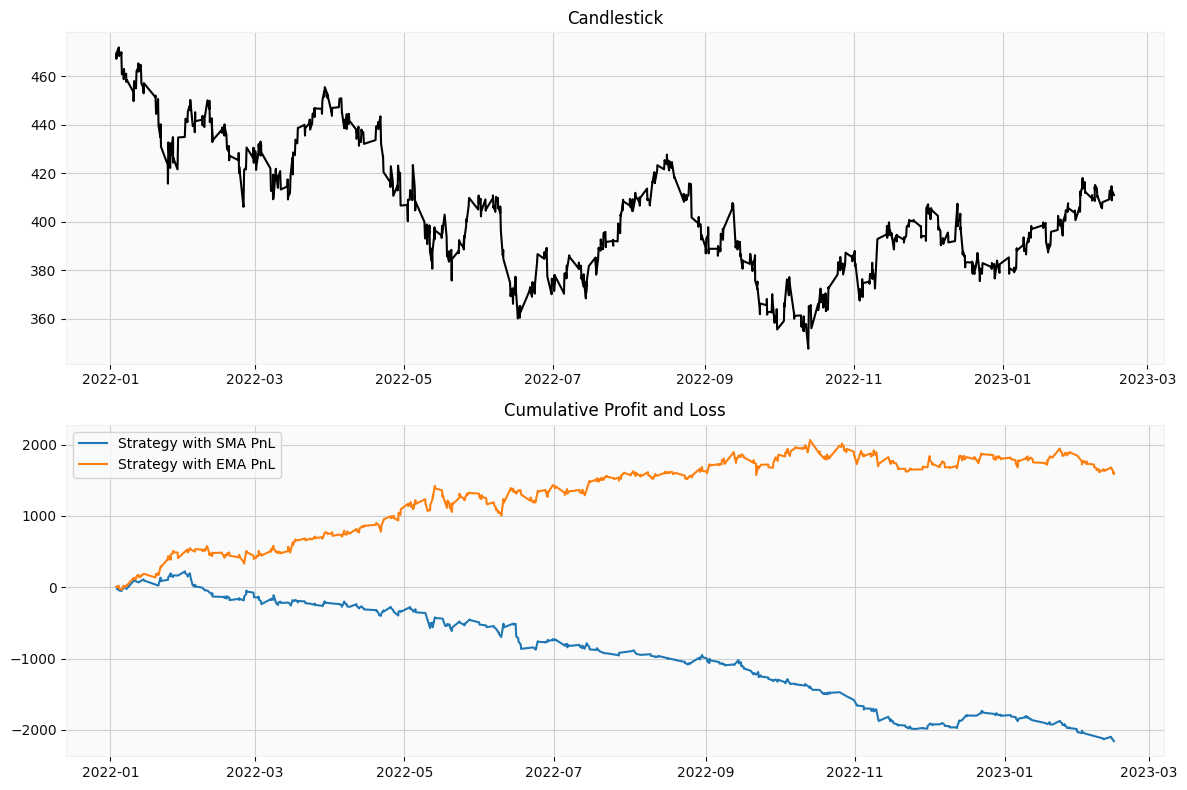

In [123]:
import matplotlib.pyplot as plt

# Create subplots using Matplotlib
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# Plot the candlestick chart
axs[0].plot(data_15m.index, data_15m['close'], color='black')
axs[0].set_title('Candlestick')

# Plot the cumulative profit and loss
axs[1].plot(trade_list.index, trade_list['pnl'].cumsum(), label='Strategy with SMA PnL')
axs[1].plot(trade_list_ema.index, trade_list_ema['pnl'].cumsum(), label='Strategy with EMA PnL')
axs[1].set_title('Cumulative Profit and Loss')
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('subplots.png')

# Display the plot
plt.show()


Metrics for Strategy with SMA

In [117]:
print("Portfolio metrics for Strategy with SMA") 
print("Win ratio", round((trade_list['pnl'] >= 0).sum() / trade_list.shape[0], 3))
# resample the returns to Business days and sum the PnL to get daily returns 
qs.reports.metrics(trade_list['return'].resample('B').sum())

Portfolio metrics for Strategy with SMA
Win ratio 0.313
                    Strategy
------------------  ----------
Start Period        2022-01-03
End Period          2023-02-14
Risk-Free Rate      0.0%
Time in Market      86.0%

Cumulative Return   -40.0%
CAGR﹪              -36.75%

Sharpe              -3.51
Prob. Sharpe Ratio  0.01%
Sortino             -4.21
Sortino/√2          -2.98
Omega               0.51

Max Drawdown        -42.0%
Longest DD Days     378

Gain/Pain Ratio     -0.49
Gain/Pain (1M)      -0.88

Payoff Ratio        1.01
Profit Factor       0.51
Common Sense Ratio  0.43
CPC Index           0.18
Tail Ratio          0.83
Outlier Win Ratio   5.45
Outlier Loss Ratio  3.71

MTD                 -3.27%
3M                  -7.13%
6M                  -25.21%
YTD                 -8.59%
1Y                  -38.13%
3Y (ann.)           -36.75%
5Y (ann.)           -36.75%
10Y (ann.)          -36.75%
All-time (ann.)     -36.75%

Avg. Drawdown       -8.97%
Avg. Drawdown Days  80
Reco

Metrics for strategy with EMA

In [118]:
print("Portfolio metrics for Strategy with EMA") 
print("Win ratio", round((trade_list_ema['pnl'] >= 0).sum() / trade_list_ema.shape[0], 3))
# resample the returns to Business days and sum the PnL to get daily returns 
qs.reports.metrics(trade_list_ema['return'].resample('B').sum())

Portfolio metrics for Strategy with EMA
Win ratio 0.357
                    Strategy
------------------  ----------
Start Period        2022-01-03
End Period          2023-02-14
Risk-Free Rate      0.0%
Time in Market      86.0%

Cumulative Return   26.45%
CAGR﹪              23.42%

Sharpe              1.4
Prob. Sharpe Ratio  93.65%
Sortino             2.22
Sortino/√2          1.57
Omega               1.29

Max Drawdown        -8.61%
Longest DD Days     123

Gain/Pain Ratio     0.29
Gain/Pain (1M)      2.5

Payoff Ratio        1.2
Profit Factor       1.29
Common Sense Ratio  1.71
CPC Index           0.8
Tail Ratio          1.33
Outlier Win Ratio   4.19
Outlier Loss Ratio  3.02

MTD                 -4.3%
3M                  -3.04%
6M                  -1.56%
YTD                 -3.75%
1Y                  16.22%
3Y (ann.)           23.42%
5Y (ann.)           23.42%
10Y (ann.)          23.42%
All-time (ann.)     23.42%

Avg. Drawdown       -1.54%
Avg. Drawdown Days  12
Recovery Factor     